## Candidato: William Henrique de Oliveira

## Teste para vaga de Cientista de Dados - Semantix

In [1]:
# Imports
import math
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder.master("local").appName("Cientista-Semantix").getOrCreate()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pima = pd.read_csv('C:/Users/william.oliveira/Desktop/Semantix/Cientista/arquivo/bank-full.csv',sep = ";")   

In [5]:
# Transforma para Dataframe
df = pd.DataFrame(pima)

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [8]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [9]:
df[pima.isnull().any(axis=1)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


In [10]:
df.isnull().values.any()

False

## Análise Exploratória

### 1. Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?'

In [11]:
df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [12]:
# Profissao de clientes que mais assinou um depósito a prazo
df[df['y'] == 'yes'].groupby(['job'])['y'].count()

job
admin.            631
blue-collar       708
entrepreneur      123
housemaid         109
management       1301
retired           516
self-employed     187
services          369
student           269
technician        840
unemployed        202
unknown            34
Name: y, dtype: int64

### Quantidade de Pessoas que tiveram assinaturas com depósito a prazo

In [13]:
df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

### 2. Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?

In [14]:
df.groupby (['contact','y']) ['y'].count( )

contact    y  
cellular   no     24916
           yes     4369
telephone  no      2516
           yes      390
unknown    no     12490
           yes      530
Name: y, dtype: int64

### Tivemos um melhor resultado, quando o contato foi por celular, e mesmo quando foi desconhecido ainda tivemos algum resultado positivo.

### 3. Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão?

In [15]:
df['duration'].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

### 4. O resultado da campanha anterior tem relevância na campanha atual?

In [16]:
df[df['y'] == 'yes'].groupby(['month','day'])['y'].count()

month  day
apr    1       13
       2        6
       3        5
       5       12
       6       15
       7        6
       8       28
       9       13
       12       6
       13      22
       14      25
       15      27
       16      30
       17      37
       19       4
       20      52
       21      27
       22      25
       23      22
       24       6
       26       8
       27      14
       28       6
       29      16
       30     152
aug    2        6
       3       12
       4       38
       5       55
       6       46
             ... 
oct    27      27
       28      11
       29      26
       30      18
       31       3
sep    1       19
       2       12
       3       11
       4       10
       6       11
       7       15
       8       24
       9       26
       10       7
       11      12
       13       3
       14      12
       15      23
       16      20
       17       7
       18       4
       20       1
       22      14
       23      13

### Podemos idenfiticar que cada vez que passa os meses a quantidade de pessoas que assinou diminui.

### 5. Qual o fator determinante para que o banco exija um seguro de crédito?

In [17]:
df[df['y'] == 'yes'].groupby(['y'])['balance'].count()

y
yes    5289
Name: balance, dtype: int64

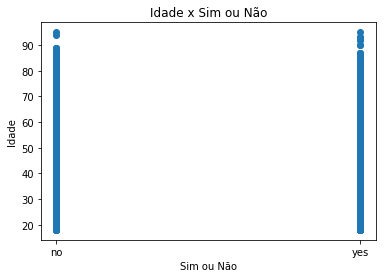

In [18]:
plt.scatter(df.y,df.age)
plt.xlabel('Sim ou Não')
plt.ylabel('Idade')
plt.title('Idade x Sim ou Não')
plt.show()

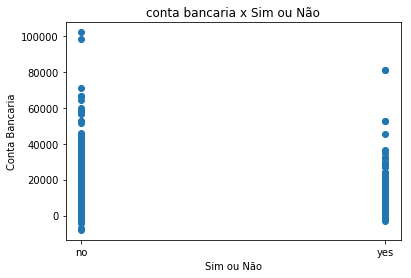

In [19]:
plt.scatter(df.y,df.balance)
plt.xlabel( 'Sim ou Não')
plt.ylabel('Conta Bancaria')
plt.title('conta bancaria x Sim ou Não')
plt.show()

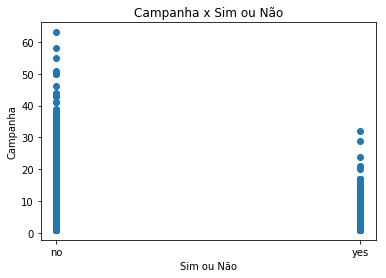

In [20]:
plt.scatter(df.y,df.campaign)
plt.xlabel('Sim ou Não')
plt.ylabel('Campanha')
plt.title('Campanha x Sim ou Não')
plt.show()

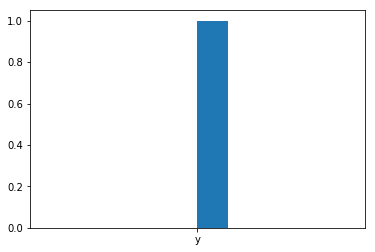

In [21]:
plt.show(plt.hist('y'))

In [22]:
df.groupby(['balance','y'])['poutcome'].count()

balance  y  
-8019    no     1
-6847    no     1
-4057    no     1
-3372    no     1
-3313    no     1
-3058    yes    1
-2827    no     1
-2712    no     1
-2604    no     1
-2282    no     1
-2122    no     1
-2093    no     1
-2082    no     1
-2049    no     1
-1980    no     1
-1968    no     1
-1965    no     1
-1944    yes    1
-1941    no     1
-1884    no     2
-1882    no     1
-1854    no     1
-1818    no     1
-1781    no     1
-1779    no     1
-1746    no     1
-1737    no     1
-1730    no     1
-1725    no     1
-1701    no     1
               ..
 37378   no     2
 38279   no     1
 39098   no     1
 39385   no     1
 41242   no     1
 41630   no     1
 41923   no     1
 42045   no     1
 43074   no     1
 44128   no     1
 44134   no     1
 45141   no     1
 45248   yes    1
 45789   no     1
 51439   no     1
 52499   no     1
 52527   no     1
 52587   yes    2
 56831   no     1
 57435   no     1
 58544   no     1
 58932   no     1
 59649   no     1
 64343   no    

### De acordo com os análises o saldo bancario é o fator determinante para identificar se o cliente assinou 

### 6. Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?

In [23]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


### Ter uma idade entre 25 a 65 anos, um saldo maior igual a 5.000 

### Quero aproveitar a oportunidade e fazer um modelo de Machine Learning

## Classificar clientes de acordo com a possibilidade de pagar ou não o crédito

In [24]:
# Carregando os dados e gerando um RDD
bankRDD = sc.textFile("C:/Users/william.oliveira/Desktop/Semantix/Cientista/arquivo/bank-full.csv") 

In [25]:
bankRDD.cache()

C:/Users/william.oliveira/Desktop/Semantix/Cientista/arquivo/bank-full.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [26]:
bankRDD.count()

45212

In [27]:
bankRDD.take(5)

['"age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"',
 '58;"management";"married";"tertiary";"no";2143;"yes";"no";"unknown";5;"may";261;1;-1;0;"unknown";"no"',
 '44;"technician";"single";"secondary";"no";29;"yes";"no";"unknown";5;"may";151;1;-1;0;"unknown";"no"',
 '33;"entrepreneur";"married";"secondary";"no";2;"yes";"yes";"unknown";5;"may";76;1;-1;0;"unknown";"no"',
 '47;"blue-collar";"married";"unknown";"no";1506;"yes";"no";"unknown";5;"may";92;1;-1;0;"unknown";"no"']

In [28]:
# Removendo a primeira linha do arquivo (cabeçalho)
firstLine = bankRDD.first()
bankRDD2 = bankRDD.filter(lambda x: x != firstLine)
bankRDD2.count()

45211

## Limpeza dos Dados

In [29]:
# Transformando os dados para valores numéricos
def transformToNumeric( inputStr) :
    
    attList = inputStr.replace("\"","").split(";")
    
    age = float(attList[0])
    outcome = 0.0 if attList[16] == "no" else 1.0
    single = 1.0 if attList[2] == "single" else 0.0
    married = 1.0 if attList[2] == "married" else 0.0
    divorced = 1.0 if attList[2] == "divorced" else 0.0
    primary = 1.0 if attList[3] == "primary" else 0.0
    secondary = 1.0 if attList[3] == "secondary" else 0.0
    tertiary = 1.0 if attList[3] == "tertiary" else 0.0
    default = 0.0 if attList[4] == "no" else 1.0
    balance = float(attList[5])
    loan = 0.0 if attList[7] == "no" else 1.0
    
    # Cria as linhas com os objetos transformados
    linhas = Row(OUTCOME = outcome, AGE = age, SINGLE = single, MARRIED = married, DIVORCED = divorced,
                 PRIMARY = primary, SECONDARY = secondary, TERTIARY = tertiary, DEFAULT = default, BALANCE = balance,
                 LOAN = loan) 
    return linhas

In [30]:
# Aplicando a função de limpeza ao conjunto de dados
bankRDD3 = bankRDD2.map(transformToNumeric)
bankRDD3.collect()[:15]

[Row(AGE=58.0, BALANCE=2143.0, DEFAULT=0.0, DIVORCED=0.0, LOAN=0.0, MARRIED=1.0, OUTCOME=0.0, PRIMARY=0.0, SECONDARY=0.0, SINGLE=0.0, TERTIARY=1.0),
 Row(AGE=44.0, BALANCE=29.0, DEFAULT=0.0, DIVORCED=0.0, LOAN=0.0, MARRIED=0.0, OUTCOME=0.0, PRIMARY=0.0, SECONDARY=1.0, SINGLE=1.0, TERTIARY=0.0),
 Row(AGE=33.0, BALANCE=2.0, DEFAULT=0.0, DIVORCED=0.0, LOAN=1.0, MARRIED=1.0, OUTCOME=0.0, PRIMARY=0.0, SECONDARY=1.0, SINGLE=0.0, TERTIARY=0.0),
 Row(AGE=47.0, BALANCE=1506.0, DEFAULT=0.0, DIVORCED=0.0, LOAN=0.0, MARRIED=1.0, OUTCOME=0.0, PRIMARY=0.0, SECONDARY=0.0, SINGLE=0.0, TERTIARY=0.0),
 Row(AGE=33.0, BALANCE=1.0, DEFAULT=0.0, DIVORCED=0.0, LOAN=0.0, MARRIED=0.0, OUTCOME=0.0, PRIMARY=0.0, SECONDARY=0.0, SINGLE=1.0, TERTIARY=0.0),
 Row(AGE=35.0, BALANCE=231.0, DEFAULT=0.0, DIVORCED=0.0, LOAN=0.0, MARRIED=1.0, OUTCOME=0.0, PRIMARY=0.0, SECONDARY=0.0, SINGLE=0.0, TERTIARY=1.0),
 Row(AGE=28.0, BALANCE=447.0, DEFAULT=0.0, DIVORCED=0.0, LOAN=1.0, MARRIED=0.0, OUTCOME=0.0, PRIMARY=0.0, SECONDARY

## Análise Exploratória de Dados

In [31]:
# Transforma para Dataframe
bankDF = spSession.createDataFrame(bankRDD3)

In [32]:
# Estatística descritiva
bankDF.describe().show()

+-------+-----------------+------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+-----------------+------------------+-------------------+
|summary|              AGE|           BALANCE|             DEFAULT|           DIVORCED|               LOAN|           MARRIED|            OUTCOME|            PRIMARY|        SECONDARY|            SINGLE|           TERTIARY|
+-------+-----------------+------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+-----------------+------------------+-------------------+
|  count|            45211|             45211|               45211|              45211|              45211|             45211|              45211|              45211|            45211|             45211|              45211|
|   mean|40.93621021432837|1362.2720576850766|0.018026586450200173|0.11517108668244454|0.160226493552454

In [33]:
# Correlação entre as variáveis
for i in bankDF.columns:
    if not( isinstance(bankDF.select(i).take(1)[0][0], str)) :
        print( "Correlação da variável OUTCOME com", i, bankDF.stat.corr('OUTCOME',i))

Correlação da variável OUTCOME com AGE 0.025155017088378997
Correlação da variável OUTCOME com BALANCE 0.05283841028818275
Correlação da variável OUTCOME com DEFAULT -0.022418965890751152
Correlação da variável OUTCOME com DIVORCED 0.0027723674615963583
Correlação da variável OUTCOME com LOAN -0.06818503472421249
Correlação da variável OUTCOME com MARRIED -0.06026038456974631
Correlação da variável OUTCOME com OUTCOME 1.0
Correlação da variável OUTCOME com PRIMARY -0.040393403131117306
Correlação da variável OUTCOME com SECONDARY -0.03638773102673158
Correlação da variável OUTCOME com SINGLE 0.06352577267582238
Correlação da variável OUTCOME com TERTIARY 0.06644826092047021


## Pré-Processamento dos Dados

In [34]:
# Criando um LabeledPoint (target, Vector[features])
def transformaVar(row) :
    obj = (row["OUTCOME"], Vectors.dense([row["AGE"], row["BALANCE"], row["DEFAULT"], row["DIVORCED"], row["LOAN"], 
                                          row["MARRIED"], row["PRIMARY"], row["SECONDARY"], row["SINGLE"], 
                                          row["TERTIARY"]]))
    return obj

In [35]:
bankRDD4 = bankDF.rdd.map(transformaVar)

In [36]:
bankRDD4.collect()

[(0.0, DenseVector([58.0, 2143.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0])),
 (0.0, DenseVector([44.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0])),
 (0.0, DenseVector([33.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0])),
 (0.0, DenseVector([47.0, 1506.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])),
 (0.0, DenseVector([33.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0])),
 (0.0, DenseVector([35.0, 231.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0])),
 (0.0, DenseVector([28.0, 447.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0])),
 (0.0, DenseVector([42.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])),
 (0.0, DenseVector([58.0, 121.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0])),
 (0.0, DenseVector([43.0, 593.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0])),
 (0.0, DenseVector([41.0, 270.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0])),
 (0.0, DenseVector([29.0, 390.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0])),
 (0.0, DenseVector([53.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0])),
 (0.0, DenseVector(

In [37]:
bankDF = spSession.createDataFrame(bankRDD4,["label", "features"])
bankDF.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[58.0,2143.0,0.0,...|  0.0|
|[44.0,29.0,0.0,0....|  0.0|
|[33.0,2.0,0.0,0.0...|  0.0|
|[47.0,1506.0,0.0,...|  0.0|
|[33.0,1.0,0.0,0.0...|  0.0|
|[35.0,231.0,0.0,0...|  0.0|
|[28.0,447.0,0.0,0...|  0.0|
|[42.0,2.0,1.0,1.0...|  0.0|
|[58.0,121.0,0.0,0...|  0.0|
|[43.0,593.0,0.0,0...|  0.0|
+--------------------+-----+
only showing top 10 rows



In [38]:
# Aplicando Redução de Dimensionalidade com PCA
bankPCA = PCA(k = 3, inputCol = "features", outputCol = "pcaFeatures")
pcaModel = bankPCA.fit(bankDF)
pcaResult = pcaModel.transform(bankDF).select("label","pcaFeatures")
pcaResult.show(truncate = False)

+-----+------------------------------------------------------------+
|label|pcaFeatures                                                 |
+-----+------------------------------------------------------------+
|0.0  |[-2143.0196711331614,57.260787034294324,-0.6784907306088993]|
|0.0  |[-29.01499011271897,43.95413163382325,0.1540681878048371]   |
|0.0  |[-2.0112362290038703,32.99802196672007,0.8212593887331948]  |
|0.0  |[-1506.015944454527,46.485276848301176,-0.01256012627826153]|
|0.0  |[-1.011251942580116,32.97120692533519,-0.4683895025831414]  |
|0.0  |[-231.0119391300792,34.91982445463028,-0.5519461776349084]  |
|0.0  |[-447.0095231918756,27.816506943280277,-0.9625726806468359] |
|0.0  |[-2.014330348908916,41.98742574623907,-0.9331743601877123]  |
|0.0  |[-121.0197747551595,57.96091684832885,-0.18846745614432547] |
|0.0  |[-593.0146161691157,42.76212195312345,0.17038030304469332]  |
|0.0  |[-270.013952545266,40.89624506099132,0.3746565058154431]    |
|0.0  |[-390.0098536541565,28.8356

In [39]:
# Indexação é pré-requisito para Decision Trees
stringIndexer = StringIndexer(inputCol = "label", outputCol = "indexed")
si_model = stringIndexer.fit(pcaResult)
obj_final = si_model.transform(pcaResult)
obj_final.collect()

[Row(label=0.0, pcaFeatures=DenseVector([-2143.0197, 57.2608, -0.6785]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-29.015, 43.9541, 0.1541]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-2.0112, 32.998, 0.8213]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-1506.0159, 46.4853, -0.0126]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-1.0113, 32.9712, -0.4684]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-231.0119, 34.9198, -0.5519]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-447.0095, 27.8165, -0.9626]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-2.0143, 41.9874, -0.9332]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-121.0198, 57.9609, -0.1885]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-593.0146, 42.7621, 0.1704]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-270.014, 40.8962, 0.3747]), indexed=0.0),
 Row(label=0.0, pcaFeatures=DenseVector([-390.0099, 28.8356, 0.263

## Machine Learning

In [40]:
# Dados de Treino e de Teste
(dados_treino, dados_teste) = obj_final.randomSplit([0.7, 0.3])

In [41]:
dados_treino.count()

31695

In [42]:
dados_teste.count()

13516

In [43]:
# Criando o modelo
rfClassifer = RandomForestClassifier(labelCol = "indexed", featuresCol = "pcaFeatures")
modelo = rfClassifer.fit(dados_treino)

In [44]:
# Previsões com dados de teste
predictions = modelo.transform(dados_teste)
predictions.select("prediction", "indexed", "label", "pcaFeatures").collect()

[Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-52527.0106, 22.086, 0.2872])),
 Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-29125.0113, 28.0662, 1.2086])),
 Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-28433.0117, 29.3021, -0.1084])),
 Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-25856.0159, 42.1771, -0.2341])),
 Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-24055.0126, 32.7858, -0.4619])),
 Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-23919.0102, 25.8113, -0.6765])),
 Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-23189.0174, 47.0853, -0.3062])),
 Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-22867.0093, 23.2025, -0.1463])),
 Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-22856.0109, 28.2153, 0.3429])),
 Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector

In [45]:
# Avaliando a acurácia
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "indexed", metricName = "accuracy")
evaluator.evaluate(predictions)

0.8813998224326723

In [46]:
# Confusion Matrix
predictions.groupBy("indexed", "prediction").count().show()

+-------+----------+-----+
|indexed|prediction|count|
+-------+----------+-----+
|    1.0|       1.0|   13|
|    0.0|       1.0|   12|
|    1.0|       0.0| 1591|
|    0.0|       0.0|11900|
+-------+----------+-----+



# Fim, Muito obrigado pela oportunidade